# Digit Images Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

In [3]:
train_len = len(train)
print('length of training', train_len)
data=pd.concat(objs=[train, test], axis=0,sort=False).reset_index(drop=True)
print('length of all data', len(data))

length of training 42000
length of all data 70000


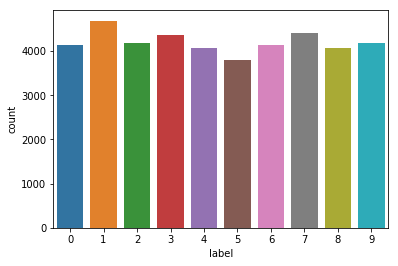

In [4]:
import seaborn as sns
sns.countplot(x='label',data=train)

In [5]:
pd.isnull(data).sum().sort_values(ascending=False).head(2)

label       28000
pixel267        0
dtype: int64

Example

8.0


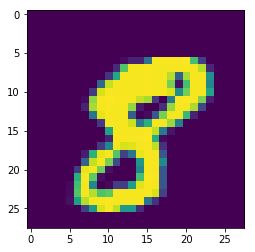

In [6]:
img=data.iloc[10,:]
import matplotlib.pyplot as plt
plt.imshow(np.reshape(img[1:].values,(28,28)))
print(img[0])

In [19]:
X=train.drop(columns='label',axis=1)
y=train['label'] # int 

In [20]:
# normalization can speed up the training
X/= 255

In [21]:
from sklearn.model_selection import train_test_split
#Split training data into training and CV sets
X_train, X_cv, y_train, y_cv = train_test_split(X,y,test_size=0.05)

In [22]:
# normalize X_test
X_test =test/255

### 1. Logistic Regression (Fast Training)

In [10]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(penalty='l2')
LR.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [11]:
print(LR.score(X_cv,y_cv))
y_cv_prediction=LR.predict(X_cv)
#predictions = LR.predict(X_test)

0.91


In [12]:
from sklearn.metrics import classification_report
#from sklearn.metrics import roc_auc_score only for binary 
print(classification_report(y_cv, y_cv_prediction ))

             precision    recall  f1-score   support

          0       0.95      0.97      0.96       202
          1       0.94      0.96      0.95       251
          2       0.93      0.87      0.90       201
          3       0.89      0.86      0.87       215
          4       0.91      0.93      0.92       198
          5       0.86      0.91      0.88       179
          6       0.95      0.95      0.95       210
          7       0.90      0.94      0.92       230
          8       0.84      0.84      0.84       195
          9       0.92      0.87      0.89       219

avg / total       0.91      0.91      0.91      2100



### 2. 4-layer Neural Network (multi-label classification)

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import adam

Using TensorFlow backend.


In [23]:
# parameters
batch_size = 128  #(2**n)
num_classes = 10
epochs = 15

In [24]:
# convert class vectors to binary class matrices 2->(0,0,1,0000)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_cv = keras.utils.to_categorical(y_cv, num_classes)

In [14]:
#X_train=np.array(X_train).astype('float32')
#X_cv=np.array(X_cv).astype('float32')
#X_test=np.array(X_test).astype('float32')

In [25]:
# initializing NN
classifier = Sequential()
# input layer and first layer
classifier.add(Dense(512, activation='relu', input_dim=(784)))
classifier.add(Dropout(0.2)) # Fraction of the input units to drop. 
classifier.add(Dense(512, activation='relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(512, activation='relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(num_classes, activation='softmax')) # 10 classes softmax for multi label classification

In [26]:
classifier.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [27]:
history = classifier.fit(X_train, y_train,\
                    batch_size=batch_size, epochs=epochs,verbose=1,validation_data=(X_cv, y_cv))
score = classifier.evaluate(X_cv, y_cv, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 39900 samples, validate on 2100 samples
Epoch 1/15
39900/39900 [==============================] - 9s 227us/step - loss: 0.3074 - acc: 0.9050 - val_loss: 0.1187 - val_acc: 0.9576
Epoch 2/15
39900/39900 [==============================] - 8s 191us/step - loss: 0.1245 - acc: 0.9617 - val_loss: 0.1029 - val_acc: 0.9681
Epoch 3/15
39900/39900 [==============================] - 7s 185us/step - loss: 0.0899 - acc: 0.9707 - val_loss: 0.0885 - val_acc: 0.9748
Epoch 4/15
39900/39900 [==============================] - 7s 170us/step - loss: 0.0676 - acc: 0.9787 - val_loss: 0.0908 - val_acc: 0.9752
Epoch 5/15
39900/39900 [==============================] - 7s 171us/step - loss: 0.0591 - acc: 0.9817 - val_loss: 0.0742 - val_acc: 0.9771
Epoch 6/15
39900/39900 [==============================] - 7s 170us/step - loss: 0.0461 - acc: 0.9852 - val_loss: 0.0933 - val_acc: 0.9752
Epoch 7/15
39900/39900 [==============================] - 7s 172us/step - loss: 0.0479 - acc: 0.9845 - val_loss: 0.0815 - v

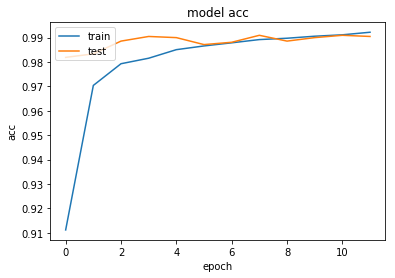

In [42]:
# summarize history for loss
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
#check mislabeled 
y_cv_pred=classifier.predict(X_cv)
index=np.where(np.argmax(y_cv_pred,axis=1) != np.argmax(y_cv, axis=1))

A Mislabeled Example 

8


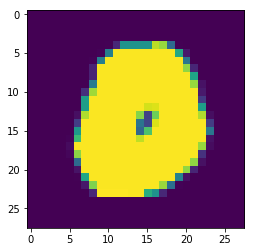

In [30]:
plt.imshow(np.reshape(X_cv.iloc[index[0][0]].values,(28,28)).reshape(28,28))
print(np.argmax(y_cv_pred[index[0][0]]))

In [31]:
predictions = classifier.predict(X_test)
classes = np.argmax(predictions, axis=1)

In [33]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_cv, axis=1),np.argmax(y_cv_pred, axis=1) ))

             precision    recall  f1-score   support

          0       0.99      0.97      0.98       208
          1       0.99      0.99      0.99       221
          2       0.97      0.99      0.98       201
          3       0.98      0.97      0.97       210
          4       0.97      0.98      0.97       181
          5       0.98      0.98      0.98       234
          6       0.98      1.00      0.99       209
          7       0.97      0.98      0.97       210
          8       0.96      0.98      0.97       209
          9       0.99      0.96      0.97       217

avg / total       0.98      0.98      0.98      2100



### Convolution Neural Network

In [34]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [35]:
X_train=np.array(X_train).astype('float32').reshape(39900,28,28,1)
X_cv=np.array(X_cv).astype('float32').reshape(2100,28,28,1)
X_test=np.array(X_test).astype('float32').reshape(28000,28,28,1)

In [36]:
# parameters
batch_size = 128  #(2**n)
num_classes = 10
epochs = 12

In [37]:
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1))) #using Tensorflow backen if Thesno, 1, 28, 28 
cnn.add(Conv2D(64, (3, 3), activation='relu'))

cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(num_classes, activation='softmax'))


In [38]:
cnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [39]:
history = cnn.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_cv, y_cv))

Train on 39900 samples, validate on 2100 samples
Epoch 1/12
39900/39900 [==============================] - 53s 1ms/step - loss: 0.2880 - acc: 0.9112 - val_loss: 0.0638 - val_acc: 0.9819
Epoch 2/12
39900/39900 [==============================] - 52s 1ms/step - loss: 0.0977 - acc: 0.9704 - val_loss: 0.0475 - val_acc: 0.9833
Epoch 3/12
39900/39900 [==============================] - 53s 1ms/step - loss: 0.0712 - acc: 0.9793 - val_loss: 0.0386 - val_acc: 0.9886
Epoch 4/12
39900/39900 [==============================] - 52s 1ms/step - loss: 0.0588 - acc: 0.9816 - val_loss: 0.0376 - val_acc: 0.9905
Epoch 5/12
39900/39900 [==============================] - 51s 1ms/step - loss: 0.0487 - acc: 0.9851 - val_loss: 0.0369 - val_acc: 0.9900
Epoch 6/12
39900/39900 [==============================] - 51s 1ms/step - loss: 0.0431 - acc: 0.9866 - val_loss: 0.0403 - val_acc: 0.9871
Epoch 7/12
39900/39900 [==============================] - 52s 1ms/step - loss: 0.0386 - acc: 0.9879 - val_loss: 0.0444 - val_acc:

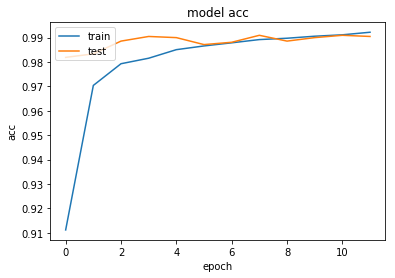

In [43]:
# summarize history for loss
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
score = cnn.evaluate(X_cv, y_cv, verbose=0)
print('loss',score[0])
print('accuracy',score[1])

loss 0.04260586598782365
accuracy 0.9904761904761905


In [45]:
y_cv_pred=cnn.predict(X_cv)
predictions = cnn.predict(X_test)

In [46]:
classes = np.argmax(predictions, axis=1)
print(classification_report(np.argmax(y_cv, axis=1),np.argmax(y_cv_pred, axis=1) ))

             precision    recall  f1-score   support

          0       1.00      0.98      0.99       208
          1       1.00      0.99      0.99       221
          2       0.99      0.99      0.99       201
          3       1.00      0.99      0.99       210
          4       0.99      0.99      0.99       181
          5       1.00      0.99      0.99       234
          6       0.99      1.00      1.00       209
          7       0.98      0.99      0.98       210
          8       0.99      1.00      0.99       209
          9       0.99      0.99      0.99       217

avg / total       0.99      0.99      0.99      2100



In [48]:
#build up a dataframe 
submission=pd.DataFrame(
    {'ImageId': range(1, len(test) + 1),
     'Label': classes
    })

#write to res.csv
import csv
submission.to_csv('res.csv', encoding='utf-8', index=False)    